In [ ]:
import torch

# Gradient Descent Training Loop in PyTorch

We can visualize the computation graph using the tool below.

In [ ]:
!pip install -qq torchviz

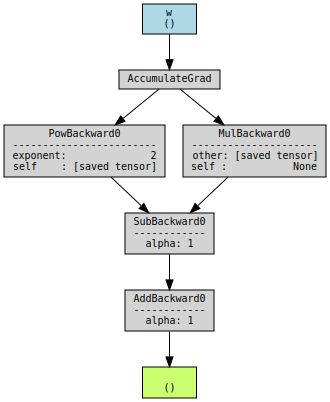

In [ ]:
from torchviz import make_dot

w = torch.tensor(2.0, requires_grad=True)
loss = w**2 - 6*w + 9

dot = make_dot(loss,
               params={"w": w},
               show_attrs=True,
              #  show_saved=True
               )
dot.render("graph", format="png")
# Display inline
from IPython.display import SVG
SVG(dot.pipe(format="svg"))

Reminder: By default, PyTorch accumulate gradient over time

In [ ]:
# Simple parameter: a scalar with grad tracking
w = torch.tensor(1.0, requires_grad=True)

# Do two forward-backward passes without clearing grads
for step in range(3):
    loss = w**2 - 6*w + 9
    loss.backward()        # compute gradient dloss/dw
    print(f"Step {step}, w.grad = {w.grad}")

Step 0, w.grad = -4.0
Step 1, w.grad = -8.0
Step 2, w.grad = -12.0




> Quiz: the correct gradient should be? How to calculate it?







Correct way: clear the gradient each step

In [ ]:
w = torch.tensor(1.0, requires_grad=True)

for step in range(3):
    loss = w**2 - 6*w + 9
    loss.backward()
    print(f"After clearing: step {step}, w.grad = {w.grad}")
    w.grad = None   # or optimizer.zero_grad(set_to_none=True)

Before clearing: step 0, w.grad = -4.0
Before clearing: step 1, w.grad = -4.0
Before clearing: step 2, w.grad = -4.0




The essential steps for training with gradient descent are:

1. **Compute the Loss (Optimization Objective)**

   * Define a loss function that measures how far the model’s predictions are from the target.
   * Example: Mean Squared Error, Cross-Entropy, etc.

   ```python
   loss = (w - 3) ** 2
   ```

2. **Backpropagation: Compute Gradients Automatically**

   * Call `.backward()` on the loss.
   * PyTorch’s autograd engine builds the computation graph and calculates the derivative of the loss with respect to parameters (`w.grad`).

   ```python
   loss.backward()
   # now w.grad contains dloss/dw
   ```

3. **Update Parameters Without Tracking the Update**

   * Use `torch.no_grad()` to prevent autograd from recording the parameter update itself.
   * Apply the gradient descent rule:

     $$
     w \; \leftarrow \; w - \alpha \cdot \nabla_w \text{loss}
     $$

   ```python
   with torch.no_grad():
       w -= lr * w.grad
   ```

4. **Clear Gradients for the Next Iteration**

   * PyTorch **accumulates** gradients by default.
   * Reset the gradient buffer so the next `backward()` call starts fresh.

   ```python
   w.grad = None
   ```




In [ ]:
# parameter (a scalar, starting at 0)
w = torch.tensor(0.0, requires_grad=True)

# learning rate
lr = 0.1

for step in range(20):
    # forward: simple quadratic loss (minimum at w=3)
    loss = w**2 -6*w + 9

    # backward: compute dloss/dw
    loss.backward()

    # update: gradient descent step (disable autograd tracking)
    with torch.no_grad():
        w -= lr * w.grad

    # clear gradient for next step
    w.grad = None

    print(f"step {step:2d} | w = {w.item():.4f} | loss = {loss.item():.4f}")


step  0 | w = 0.6000 | loss = 9.0000
step  1 | w = 1.0800 | loss = 5.7600
step  2 | w = 1.4640 | loss = 3.6864
step  3 | w = 1.7712 | loss = 2.3593
step  4 | w = 2.0170 | loss = 1.5100
step  5 | w = 2.2136 | loss = 0.9664
step  6 | w = 2.3709 | loss = 0.6185
step  7 | w = 2.4967 | loss = 0.3958
step  8 | w = 2.5973 | loss = 0.2533
step  9 | w = 2.6779 | loss = 0.1621
step 10 | w = 2.7423 | loss = 0.1038
step 11 | w = 2.7938 | loss = 0.0664
step 12 | w = 2.8351 | loss = 0.0425
step 13 | w = 2.8681 | loss = 0.0272
step 14 | w = 2.8944 | loss = 0.0174
step 15 | w = 2.9156 | loss = 0.0111
step 16 | w = 2.9324 | loss = 0.0071
step 17 | w = 2.9460 | loss = 0.0046
step 18 | w = 2.9568 | loss = 0.0029
step 19 | w = 2.9654 | loss = 0.0019


# Logistic Regression Model using PyTorch

## Simplest Data

Start with a simple synthetic dataset. Then we will see whether a logistic reg model can capture the pattern.


* map $x_1 \cdots x_3$ to a binary label $y$.
* $x_2$ and $x_3$ form a linear combination, when greater than 1, output positive labels.
* $x_1$ is always 1. It acts as a constant base value.
* add some noise



$$
\begin{aligned}
&\textbf{Data:}\quad x \in \mathbb{R}^{n \times 3}, \qquad
x_i = \begin{bmatrix} 1 & z_{i1} & z_{i2} \end{bmatrix}, \quad
\begin{bmatrix}z_{i1}\\ z_{i2}\end{bmatrix} \sim \mathcal{N}\!\left( \begin{bmatrix}0\\0\end{bmatrix}, I_2 \right) \\[8pt]
&\textbf{Noise:}\quad \epsilon_i \sim \mathcal{N}(0,\,0.1^2)\ \text{i.i.d.} \\[8pt]
&\textbf{Ground-truth weights:}\quad
w_1 = 0,\quad w_2 = 1,\quad w_3 = 1 \\[8pt]
&\textbf{Labels:}\quad
y_i =
\begin{cases}
1, & \text{if } \underbrace{w_1 x_{i,1}}_{\;0}
+ \underbrace{w_2 x_{i,2}}_{\;1 \cdot x_{i,2}}
+ \underbrace{w_3 x_{i,3}}_{\;1 \cdot x_{i,3}}
+ \epsilon_i > 1 \\[6pt]
0, & \text{otherwise}
\end{cases}
\qquad (i=1,\dots,n) \\[12pt]
&\textbf{Decision boundary:}\quad
x_{i,2} + x_{i,3} = 1
\quad \text{(a hyperplane in the feature space).}
\end{aligned}
$$


### data gen code

In [ ]:
def generate_data(n):
    xRaw = torch.randn( (n,2) ) # Generating a scatterplot of 2D data points, centered in a 'normal' way around (0,0)
    x = torch.ones( (n,3) )
    x[:,1] = xRaw[:,0]
    x[:,2] = xRaw[:,1]

    # Worth mentioning here the concept of slicing
    # For a tensor a, a[i,j] would get the i,j component
    # But a[:,j] would get a tensor of 'all' the j components, for i from 0 to whatever the largest i is
    # So in the first step I am taking the 0-th column of xRaw, and saving it in the 1-th column of x
    # Then taking the 1-th column of xRaw, and saving it in the 2-th column of x
    # And the 0th column of x remains all 1s.
    # The exact same thing could be accomplished by taking x[:,[1,2]] = xRaw

    y = torch.zeros( (n,1) ) # For each of n rows, we will save a label that is either 0 or 1

    for i in range(n):
        noise = ( torch.randn( 1 ) * 0.1 ).item()

        # if x1 + x2 + (a little bit of noise) > 0, call that a 1, else, call it a 0
        # So the 'line of best division should be 1*x1 + 1*x2 = 0

        if 0 * x[i,0] + 1 * x[i,1] + 1 * x[i,2] + noise > 0:
            y[i,0] = 1
        else:
            y[i,0] = 0

    return x,y

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

def visualize_data(x,y):

    # Convert to numpy for plotting
    x_np = x.numpy()
    y_np = y.numpy().flatten()

    df = {
        "x1": x_np[:,0],
        "x2": x_np[:,1],
        "x3": x_np[:,2],
        'y': y_np
    }

    fig = px.scatter_3d(
        df, x="x1", y="x2", z="x3",
        color="y", symbol="y",
        title="Interactive 3D Data Visualization"
    )
    fig.show()

### visualize data

In [ ]:
n_data = 500

x,y = generate_data( n_data )
print("Initial Data")
print( "X shape: ", x.shape )
print( "y shape: ", y.shape )

for i in range(10):
    print("x:", x[i,:], "\ty:", y[i,0])

visualize_data(x,y)

Initial Data
X shape:  torch.Size([500, 3])
y shape:  torch.Size([500, 1])
x: tensor([ 1.0000, -2.1156,  2.0184]) 	y: tensor(0.)
x: tensor([ 1.0000, -1.3553,  0.9044]) 	y: tensor(0.)
x: tensor([1.0000, 0.6804, 0.2817]) 	y: tensor(1.)
x: tensor([1.0000, 2.0781, 1.3867]) 	y: tensor(1.)
x: tensor([ 1.0000,  1.6909, -0.3818]) 	y: tensor(1.)
x: tensor([1.0000, 0.5801, 0.0200]) 	y: tensor(1.)
x: tensor([1.0000, 0.3993, 0.3456]) 	y: tensor(1.)
x: tensor([ 1.0000, -1.1666, -0.4407]) 	y: tensor(0.)
x: tensor([ 1.0000, -0.3281, -0.1969]) 	y: tensor(0.)
x: tensor([ 1.0000,  1.5103, -0.2675]) 	y: tensor(1.)


Logistic model:

$$
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n)}}
$$

We are using a simpler version below:

$$
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-(w_0 x_1+ w_1 x_2 + w_2 x_3)}}
$$

Note: $x_1$ is always 1 in our setting. so the model works as:

$$
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-(w_0+ w_1 x_2 + w_2 x_3)}}
$$


In [ ]:
def compute_logistic_model(
      x: torch.Tensor,  # shape = (data_size, variable_num)
      w: torch.Tensor,  # shape = (1, variable_num)
    )-> torch.Tensor:  # shape = (data_size, 1)
    """
    Compute logistic regression predictions.

    Args:
        x (torch.Tensor): Input features of shape (data_size, variable_num).
        w (torch.Tensor): Weight vector of shape (1, variable_num).

    Returns:
        torch.Tensor: Predicted probabilities of shape (data_size, 1).
    """

    raise NotImplementedError("Quiz: implement yourself!")

    return y_prob # return tensor will a predicted probability, one for each row of the original input tensor x


In [ ]:
def test_accuracy(x,y,w,n):
    y_prob = compute_logistic_model(x,w) # for each x, compute the probablity that x should be labeled 1
    # note that the probability it should be labeled 0 is 1 - (that probablity)

    misclassifications = 0
    for i in range(n):
        if y_prob[i,0] >= 0.5 and y[i,0] == 0:# if probability is high but tag is 0, bad!
            misclassifications += 1
        elif y_prob[i,0] < 0.5 and y[i,0] == 1:# if probability is low but tag is 1, bad!
            misclassifications += 1

    return 1 - misclassifications / n # accuracy is 1 - (errors)

The loss function for logistic regression (binary classification) is:

$$
J(\mathbf{w}) \;=\; -\frac{1}{N} \sum_{i=1}^N \Big( y_i \log\big( \hat{y}_i \big) + (1 - y_i)\log\big(1 - \hat{y}_i\big) \Big)
$$

where

- $N$ is the number of training examples  
- $y_i \in \{0,1\}$ is the true label for example $i$  
- $\hat{y}_i$ is the model’s predicted probability that $y_i = 1$


In [ ]:
import torch
import matplotlib.pyplot as plt

def fit(x, y, num_epochs=100, alpha=0.2):
    """
    Trains a logistic model with gradient descent, logging weights, loss, and accuracy.
    At the end, draws three figures: weights vs. epoch, loss vs. epoch, accuracy vs. epoch.
    Returns (w, history) where history contains lists for 'loss', 'acc', and 'weights'.
    """
    n_var = x.shape[1]
    n_data = x.shape[0]

    # Parameters
    w = torch.nn.Parameter(torch.randn((1, n_var)), requires_grad=True)

    # Histories
    loss_hist = []
    acc_hist = []
    weights_hist = []  # list of 1 x n_var tensors (detached)

    for i in range(num_epochs):
        y_prob = compute_logistic_model(x, w)
        # Binary cross-entropy (log-loss)
        loss_by_data_point = None
        raise NotImplementedError("Quiz: implement loss_by_data_point yourself!")
        loss = torch.mean(loss_by_data_point)

        loss.backward()
        with torch.no_grad():
            w -= alpha * w.grad
        w.grad = None

        # Log metrics
        loss_hist.append(loss.item())
        acc_hist.append(test_accuracy(x, y, w, n_data))
        weights_hist.append(w.detach().clone().view(-1))  # shape: (n_var,)

    # ----- PLOTTING -----
    epochs = list(range(1, num_epochs + 1))
    W = torch.stack(weights_hist)  # shape: (num_epochs, n_var)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    # 1) Weights
    for j in range(n_var):
        axes[0].plot(epochs, W[:, j], label=f"w[{j}]")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Value")
    axes[0].set_title("Weights vs. Epoch")
    axes[0].legend()
    axes[0].grid(True)

    # 2) Loss
    axes[1].plot(epochs, loss_hist)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Log Loss")
    axes[1].set_title("Loss vs. Epoch")
    axes[1].grid(True)

    # 3) Accuracy
    axes[2].plot(epochs, acc_hist)
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_title("Accuracy vs. Epoch")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    history = {"loss": loss_hist, "acc": acc_hist, "weights": weights_hist}
    return W[-1].detach().cpu().numpy(), history, y_prob


  # Some things to note
  # - The loop is done to 1000 iterations - this is arbitrary and could be changed. How?
  # - The choice of stepsize? Arbitrary, could be changed.


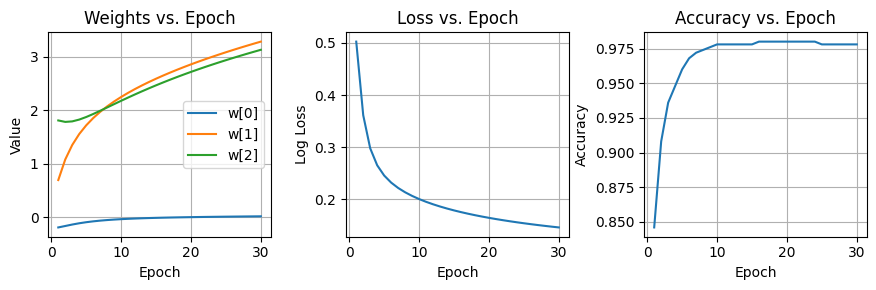

In [ ]:
w, history, y_prob = fit(x,y, num_epochs=30, alpha=2)

### Quiz

*   Why the weights are increasing?



In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def show_boundary(w, x, y):

  # Example fitted parameters (replace with your learned weights)
  w_np = w
  # w_np = np.array([0.2, -0.4, -0.1])
  print(w)

  # Generate a grid of (x1, x2)
  x1_range = np.linspace(-3, 3, 30)
  x2_range = np.linspace(-3, 3, 30)
  x2, x3 = np.meshgrid(x1_range, x2_range)


  x1 = (w_np[0] + w_np[1]*x2 + w_np[2]*x3)


  y_np = y.detach().cpu().numpy() if hasattr(y, "detach") else y.numpy()
  y_np = y_np[:,0]

  # Scatter plot of your data (X shape: [n_samples, 3], y labels)
  fig = px.scatter_3d(
      x=x[:,0], y=x[:,1], z=x[:,2],
      color=y_np.astype(str), opacity=0.7,
      labels={"x": "x1", "y": "x2", "z": "x3"},
      title="Logistic Regression Decision Boundary"
  )

  # Add decision boundary plane
  fig.add_traces(go.Surface(
      x=x1, y=x2, z=x3,
      opacity=0.4,
      colorscale="Blues",
      showscale=False
  ))

  fig.show()


In [ ]:
show_boundary(w,x,y)

[0.02000517 3.2857287  3.1328964 ]


## More complex data

Construct a dataset where linear logistic model does not work:

$$
\begin{aligned}
&\textbf{Data:}\quad x \in \mathbb{R}^{n \times 3}, \qquad
x_i = \begin{bmatrix} 1 & z_{i1} & z_{i2} \end{bmatrix}, \quad
\begin{bmatrix}z_{i1}\\ z_{i2}\end{bmatrix} \sim \mathcal{N}\!\left( \begin{bmatrix}0\\0\end{bmatrix}, I_2 \right) \\[8pt]
&\textbf{Noise:}\quad \epsilon_i \sim \mathcal{N}(0,\,0.1^2)\ \text{i.i.d.} \\[8pt]
&\textbf{Ground-truth weights:}\quad
w_1 = 0,\quad w_2 = 1,\quad w_3 = 1 \\[8pt]
&\textbf{Labels:}\quad
y_i =
\begin{cases}
1, & \text{if } \underbrace{w_1 x_{i,1}}_{\;0}
+ \underbrace{w_2 x_{i,2}^2}_{\;1 \cdot x_{i,2}^2}
+ \underbrace{w_3 x_{i,3}^2}_{\;1 \cdot x_{i,3}^2}
+ \epsilon_i > 1 \\[6pt]
0, & \text{otherwise}
\end{cases}
\qquad (i=1,\dots,n) \\[12pt]
&\textbf{Decision boundary:}\quad
x_{i,2}^2 + x_{i,3}^2 = 1
\quad \text{(unit circle in the feature space).}
\end{aligned}
$$



In [ ]:
def generate_data_2(n):
    xRaw = torch.randn( (n,2) )
    x = torch.ones( (n,3) )
    x[:,[1,2]] = xRaw

    y = torch.zeros( (n,1) )
    for i in range(n):
        noise = ( torch.randn( 1 ) * 0.1 ).item()

        if (x[i,1])**2 + (x[i,2])**2 + noise > 1:
            # Everything here is the same as in the previous code except for this part here
            # Notice that in this part, the dividing line is actually a circle, centered at 0, radius 1,
            # i.e., x1^2 + x2^2 + (noise) > 1 - if you're outside this circle, y = 1, if you're inside this circle, y = 0

            # This means that -no linear model- can fit the data 'well'

            y[i,0] = 1
        else:
            y[i,0] = 0

    return x,y

In [ ]:
n_data = 1000

x,y = generate_data_2( n_data )
print("Initial Data")
print( "X shape: ", x.shape )
print( "y shape: ", y.shape )

for i in range(10):
    print("x:", x[i,:], "\ty:", y[i,0])

visualize_data(x,y)

Initial Data
X shape:  torch.Size([1000, 3])
y shape:  torch.Size([1000, 1])
x: tensor([ 1.0000, -1.7572, -1.1690]) 	y: tensor(1.)
x: tensor([ 1.0000,  0.4842, -1.5656]) 	y: tensor(1.)
x: tensor([ 1.0000,  1.7135, -0.4174]) 	y: tensor(1.)
x: tensor([ 1.0000,  0.9479, -0.8495]) 	y: tensor(1.)
x: tensor([ 1.0000, -0.0708, -0.4888]) 	y: tensor(0.)
x: tensor([1.0000, 0.5155, 0.7597]) 	y: tensor(0.)
x: tensor([ 1.0000, -1.3883,  1.0952]) 	y: tensor(1.)
x: tensor([ 1.0000,  0.1688, -0.7055]) 	y: tensor(0.)
x: tensor([ 1.0000, -0.0044,  0.6089]) 	y: tensor(0.)
x: tensor([1.0000, 1.1240, 2.0679]) 	y: tensor(1.)


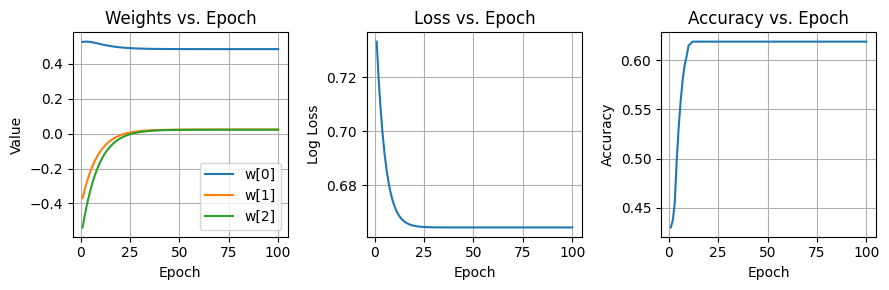

In [ ]:
w, history, y_prob = fit(x,y, alpha=0.5)

In [ ]:
print(w)

[0.48492527 0.02352061 0.02295538]


### Quiz

* what is the current prediction behavior?

Remind our logistic model is:

$$
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-(w_0+ w_1 x_2 + w_2 x_3)}}
$$


## More complex structure

Use a more complex model structure.

Instead of Logistic model using linear combination:

$$
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n)}}
$$

we use polynomial combinations between variables:

$$
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1^2 + \beta_2 x_2^2 + \beta_3 x_1 x_2+\cdots)}}
$$



Precompute the polynomial terms in the input data.

$$
\begin{aligned}
&\textbf{Base features:}\quad
\begin{bmatrix}z_{i1}\\ z_{i2}\end{bmatrix}
\stackrel{\text{i.i.d.}}{\sim}
\mathcal{N}\!\left(\begin{bmatrix}0\\0\end{bmatrix},\,I_2\right),
\qquad i=1,\dots,n \\[6pt]
&\textbf{Expanded (polynomial) input:}\quad
x_i=\phi(z_i)=
\begin{bmatrix}
1 & z_{i1} & z_{i2} & z_{i1}^2 & z_{i2}^2 & z_{i1}z_{i2}
\end{bmatrix}\in\mathbb{R}^{6} \\[6pt]
&\textbf{Noise:}\quad \epsilon_i \stackrel{\text{i.i.d.}}{\sim}\mathcal{N}(0,\,0.1^2) \\[8pt]
&\textbf{Labels (linear in expanded features):}\quad
y_i=
\begin{cases}
1, & \text{if } \displaystyle \sum_{j=1}^{6} w_j\,x_{i,j} + \epsilon_i > 0 \\[6pt]
0, & \text{otherwise}
\end{cases} \\[10pt]
&\textbf{Ground-truth weights:}\quad
\boxed{w_1=\mathbf{-1},\;\; w_2=\mathbf{0},\;\; w_3=\mathbf{0},\;\; w_4=\mathbf{1},\;\; w_5=\mathbf{1},\;\; w_6=\mathbf{0}} \\[8pt]
&\textbf{Decision boundary:}\quad
-1 + x_{i,4} + x_{i,5} = 0
\;\;\Longleftrightarrow\;\;
z_{i1}^{2}+z_{i2}^{2}=1,
\end{aligned}
$$

Thus a **linear** classifier in the expanded feature space $\phi(z)$ exactly represents the **quadratic** circle boundary in the original space.


In [ ]:
def generate_data_3(n):
    xRaw = torch.randn( (n,2) )
    y = torch.zeros( (n,1) )
    for i in range(n):
        noise = ( torch.randn( 1 ) * 0.1 ).item()

        if (xRaw[i,0])**2 + (xRaw[i,1])**2 + noise > 1:
            y[i,0] = 1
        else:
            y[i,0] = 0

    # Here I modify the data generation slightly.
    # The y values are still set based on x1^2 + x2^2 > 1
    # But I additionally compute quadratic features of the data
    # So each input x vector becomes (1, x1, x2, x1^2, x2^2, x1*x2)
    # Note that a linear model on this data, a*1 + b*x1 + c*x2 + d*x1^2 + e*x2^2 + f*x1*x2 > 0
    # captures the 'true' model of x1^2 + x2^2 > 1

    # So by doing linear logistic regression on this 'slightly expanded' data set,
    # we are actually doing quadratic logistic regression on the original data set.

    x = torch.ones( (n,6) )
    x[:,[1,2]] = xRaw
    x[:,3] = xRaw[:,0] * xRaw[:,0]
    x[:,4] = xRaw[:,1] * xRaw[:,1]
    x[:,5] = xRaw[:,1] * xRaw[:,0]

    return x,y

In [ ]:
x,y = generate_data_3(500)
print("Initial Data")
print( "X shape: ", x.shape )
print( "y shape: ", y.shape )

for i in range(10):
    print("x:", x[i,:], "\ty:", y[i,0])


Initial Data
X shape:  torch.Size([500, 6])
y shape:  torch.Size([500, 1])
x: tensor([ 1.0000, -0.8153, -1.1347,  0.6648,  1.2876,  0.9252]) 	y: tensor(1.)
x: tensor([ 1.0000,  0.0552, -0.6282,  0.0030,  0.3946, -0.0347]) 	y: tensor(0.)
x: tensor([ 1.0000, -1.3509, -1.8794,  1.8250,  3.5322,  2.5390]) 	y: tensor(1.)
x: tensor([ 1.0000, -0.6619, -0.4091,  0.4381,  0.1673,  0.2708]) 	y: tensor(0.)
x: tensor([ 1.0000, -1.2609, -0.1686,  1.5899,  0.0284,  0.2126]) 	y: tensor(1.)
x: tensor([ 1.0000, -0.5527, -1.9784,  0.3055,  3.9141,  1.0935]) 	y: tensor(1.)
x: tensor([1.0000, 1.6914, 1.9666, 2.8607, 3.8676, 3.3263]) 	y: tensor(1.)
x: tensor([ 1.0000, -0.9318,  0.5220,  0.8683,  0.2725, -0.4864]) 	y: tensor(1.)
x: tensor([1.0000, 1.3559, 0.4802, 1.8384, 0.2306, 0.6511]) 	y: tensor(1.)
x: tensor([ 1.0000, -0.7640, -1.6383,  0.5837,  2.6840,  1.2517]) 	y: tensor(1.)


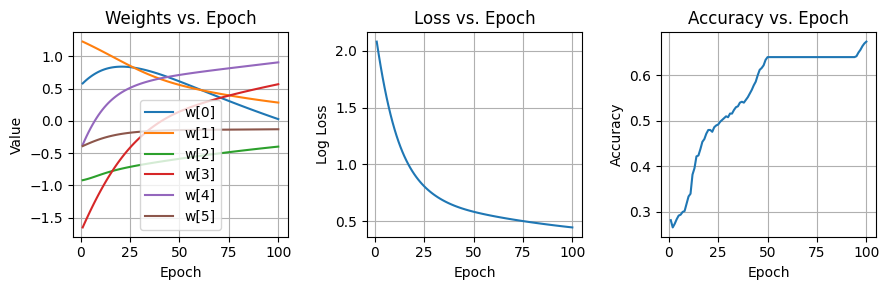

In [ ]:
w, history, y_prob = fit(x,y, num_epochs=100, alpha=0.1)

In [ ]:
w

array([ 0.02631829,  0.28236228, -0.39933968,  0.5669223 ,  0.9054642 ,
       -0.1306683 ], dtype=float32)

In [ ]:

def show_boundary2(w_np, x, y):

  print(w_np)

  # Generate a grid of (x1, x2)
  x1_range = np.linspace(-3, 3, 50)
  x2_range = np.linspace(-3, 3, 50)
  x2, x3 = np.meshgrid(x1_range, x2_range)


  x1 = (w_np[0] + w_np[1]*x2 + w_np[2]*x3 + w_np[3]*x2**2 + w_np[4]*x3**2 + w_np[5]*x2*x3)


  y_np = y.detach().cpu().numpy() if hasattr(y, "detach") else y.numpy()
  y_np = y_np[:,0]

  # Scatter plot of your data (X shape: [n_samples, 3], y labels)
  fig = px.scatter_3d(
      x=x[:,0], y=x[:,1], z=x[:,2],
      color=y_np.astype(str), opacity=0.7,
      labels={"x": "x1", "y": "x2", "z": "x3"},
      title="Logistic Regression Decision Boundary"
  )

  # Add decision boundary plane
  fig.add_traces(go.Surface(
      x=x1, y=x2, z=x3,
      opacity=0.4,
      colorscale="Blues",
      showscale=False
  ))

  fig.show()


In [ ]:
show_boundary2(w,x,y)

[ 0.02631829  0.28236228 -0.39933968  0.5669223   0.9054642  -0.1306683 ]
